 ![Drugs4Covid](https://drugs4covid.oeg-upm.net/static/media/logo.min.c1d79895.svg) **Drugs4Covid Search Engine**
 

## Preparation

In [19]:
!pip install pysolr

!wget -N "https://raw.githubusercontent.com/oeg-upm/drugs4covid19-nlp/master/notebooks/auxfunctions.py"

--2020-04-22 01:16:58--  https://raw.githubusercontent.com/oeg-upm/drugs4covid19-nlp/master/notebooks/auxfunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [text/plain]
Saving to: ‘auxfunctions.py’

auxfunctions.py     100%[===================>]   1.01K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2020-04-22 01:16:58 (155 MB/s) - ‘auxfunctions.py’ saved [1038/1038]



## Search

,Article,Paragraph
0,The 45th Annual Meeting of the European Society for Blood and Marrow Transplantation: Physicians -Poster Sessionannual-meeting,"The patients who received ruxolitinib within 14 days after aGVHD onset have a significant higher CR rate that those with delayed ruxolitinib therapy (96.2% vs. 42.9%, p=0.001). And the patients without gut infections have a significant higher CR rate than infected cohort (92.6% vs. 46.2%, p=0.002). ..."
1,unknown,"In order to examine the impact of IFNAR signaling on the DPV replication in each cell type, the IFNAR-specific inhibitor, ruxolitinib, was applied. The cell toxicity of ruxolitinib at a dose of 1, 5, 10, and 20 μM/ml on each cell type was detected by MTT method. Duck DEFs, neurons, astrocytes, PBMCs..."
2,unknown,P3 (follow-up of 12 months) after ten months on treatment on ruxolitinib presented clinical and radiological relapse of lung disease requiring glucocorticoid therapy (2 mg/kg/day of prednisone) with a prompt response (Fig. 2a) . She never presented viral or bacterial infections since the beginning o...
3,The 45th Annual Meeting of the European Society for Blood and Marrow Transplantation: Physicians -Poster Sessionannual-meeting,"Disclosure: Nothing to declare. Background: Although steroids remain first-line therapy for the treatment of acute graft versus host disease (aGVHD), response rates in patients with grade III-IV disease are poor, with no apparent improvement in survival over the past 15 years. We performed a prospec..."
4,unknown,"Nadat in 2002 in dit tijdschrift de eerste Nederlandse patiënt was beschreven met fatale miliaire tuberculose tijdens behandeling met een TNF-α-blokker, is screening op latente tuberculose-infectie voorafgaand aan het gebruik van deze middelen standaardbeleid geworden. [2] [3] Ruxolitinib is geen di..."
5,APOL1-Associated Collapsing Focal Segmental Glomerulosclerosis in a Patient With Stimulator of Interferon Genes (STING)-Associated Vasculopathy With Onset in Infancy (SAVI),"The patient was treated with methylprednisolone, 30 mg/kg daily, and treatment with ruxolitinib (2.5 mg twice daily) was restarted. He continued to have nephroticrange proteinuria and a kidney biopsy was performed...."
6,unknown,"Finally, it is important to consider that ruxolitinib inhibits not only the signaling of type I interferon receptor but also that of other receptors involved in important inflammatory pathways such as IL6, IL12/23, and interferon γ. It is possible that the inhibition of some or all of these pathways..."
7,The 45th Annual Meeting of the European Society for Blood and Marrow Transplantation: Physicians -Poster Sessionannual-meeting,"Median time of GVHD diagnosis was 47,5 days (6-525). All GVHD episodes were treated with corticosteroids as first line, with maximum doses between 1-5 mg/kg/day (the main dose used was 2 mg/kg/day, 15/22 episodes). Patients received a median number of 3,5 (2-7) previous lines of treatment including ..."
8,The 45th Annual Meeting of the European Society for Blood and Marrow Transplantation: Physicians -Poster Sessionannual-meeting,"Methods: We analyzed retrospectively clinical experience with ruxolitinib in patients (n=15) with grade 2~4 steroid-refractory acute GVHD patients compared with the control group not receiving ruxolitinib. In addition, immune status was evaluated about 6 weeks~8 weeks after the administration of rux..."
9,The 45th Annual Meeting of the European Society for Blood and Marrow Transplantation: Physicians – Poster Session,"Methods: We analyzed retrospectively clinical experience with ruxolitinib in patients (n=15) with grade 2~4 steroid-refractory acute GVHD patients compared with the control group not receiving ruxolitinib. In addition, immune status was evaluated about 6 weeks ~ 8 weeks after the administration of r..."


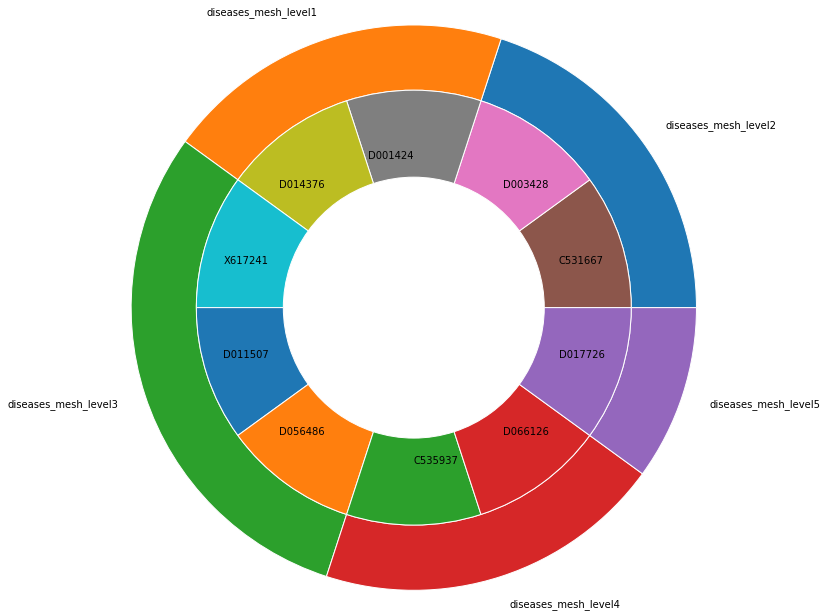

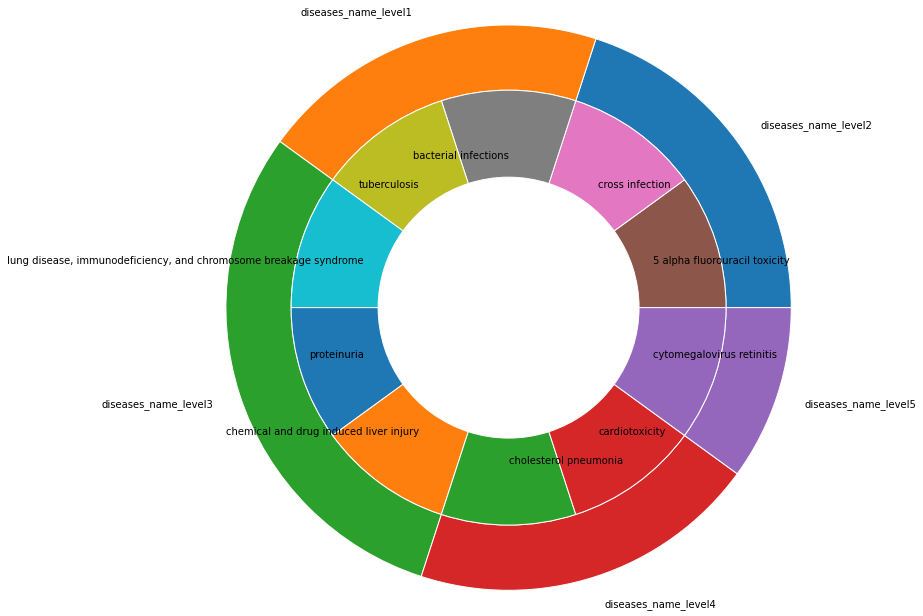

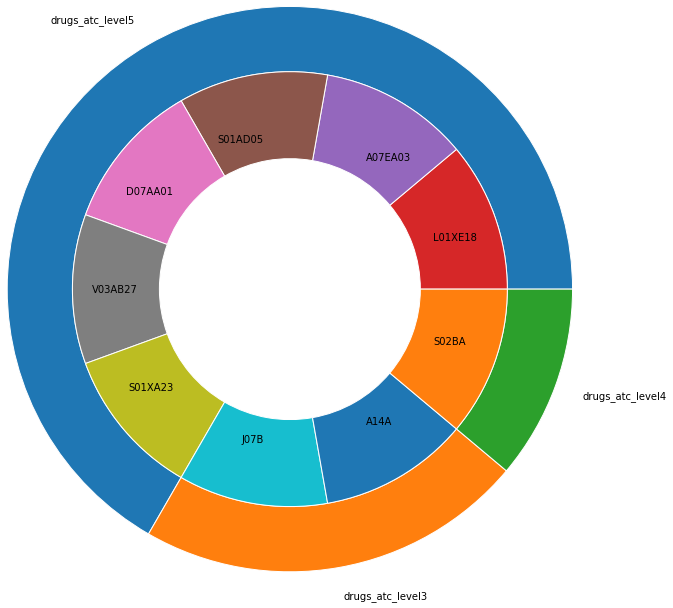

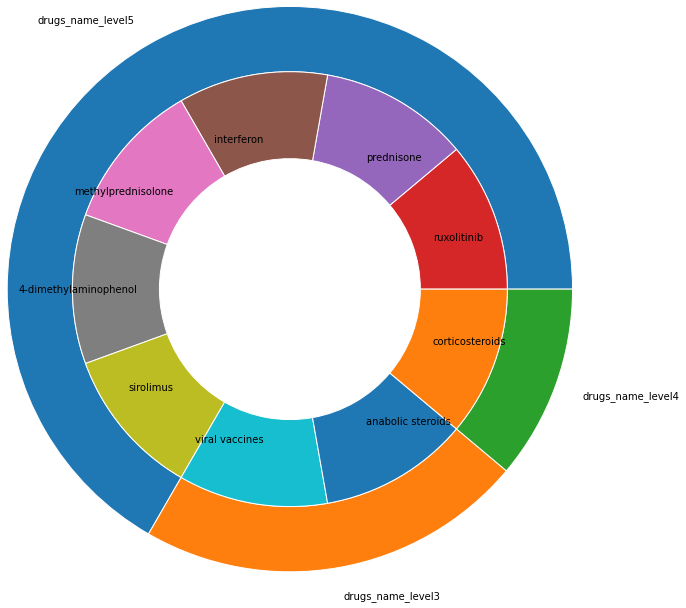

In [20]:
import auxfunctions
import requests
import pysolr
import pandas as pd
from IPython.display import display, HTML
  
keywords =  "Ruxolitinib"#@param {type:"string"}

number = 10 #@param {type:"slider", min:1, max:20, step:1}

#confidence = 100 #@param {type:"slider", min:50, max:100, step:1}

solr_drugs = pysolr.Solr('http://librairy.linkeddata.es/data/atc')
solr_diseases = pysolr.Solr('http://librairy.linkeddata.es/data/diseases')
solr_articles = pysolr.Solr('http://librairy.linkeddata.es/data/covid')
solr_paragraphs = pysolr.Solr('http://librairy.linkeddata.es/data/covid-paragraphs')

# is a drug?
drugs = solr_drugs.search(q="label_t:\""+keywords+"\" or code_s:"+keywords + " or id:" + keywords)
filter_by_drugs = []
for drug in drugs:
  level = drug['level_i']
  filter_by_drugs.append("bionlp_drugs_C"+str(level)+":"+drug['id'])

diseases = solr_diseases.search(q="name_t:\""+keywords+"\" or id:"+keywords + " or synonyms:\""+keywords+"\" or mappings=\"" + keywords + "\"")
filter_by_diseases = []
for disease in diseases:
  level = disease['level_i']
  filter_by_diseases.append("bionlp_diseases_C"+str(level)+":"+disease['id'])
  

solr_query = "text_t:\""+keywords+"\""
for drug_filter in filter_by_drugs:
  solr_query += " or " + drug_filter
for disease_filter in filter_by_diseases:
  solr_query += " or " + disease_filter  

paragraphs = solr_paragraphs.search(q=solr_query,rows=number)

def make_clickable(label,url):
    return '<a href="{}" target="_blank">{}</a>'.format(url,label)

related_drugs_code = {}
related_diseases_code = {}
related_drugs_name = {}
related_diseases_name = {}

# list of articles

articles_df = pd.DataFrame(columns=['Article', 'Paragraph'])
j=0
for paragraph in paragraphs:
  title = "unknown"
  url = ""
  purl="https://librairy.linkeddata.es/solr/covid-paragraphs/select?q=id:"+paragraph['id']
  for r in  solr_articles.search("id:"+paragraph['article_id_s']):
    if ('name_s' in r and 'url_s' in r):
      title = r['name_s']
      url = r['url_s']
  articles_df.loc[j] = [make_clickable(title,url),make_clickable(paragraph['text_t'][:300]+"...",purl)]
  for i in range(0,20):
    disease_key = 'bionlp_diseases_C'+str(i)
    if (disease_key in paragraph):
      if (not disease_key in related_diseases_code):
        related_diseases_code[disease_key] = []
        related_diseases_name[disease_key] = []
      related_diseases_code[disease_key].extend(paragraph['bionlp_diseases_C'+str(i)])
      related_diseases_name[disease_key].extend(paragraph['bionlp_diseases_N'+str(i)])
    drug_key = 'bionlp_drugs_C'+str(i)
    if (drug_key in paragraph):
      if (not drug_key in related_drugs_code):
        related_drugs_code[drug_key] = []
        related_drugs_name[drug_key] = []
      related_drugs_code[drug_key].extend(paragraph['bionlp_drugs_C'+str(i)])    
      related_drugs_name[drug_key].extend(paragraph['bionlp_drugs_N'+str(i)])    
  j+=1
  

display(HTML(articles_df.to_html(justify='left',escape=False)))
 
auxfunctions.build_donut_plot(related_diseases_code,"diseases_mesh").show()
auxfunctions.build_donut_plot(related_diseases_name,"diseases_name").show()
auxfunctions.build_donut_plot(related_drugs_code,"drugs_atc").show()
auxfunctions.build_donut_plot(related_drugs_name,"drugs_name").show()

